# Family of Data Augmentations in Contrastive Learning

## Intuition Behind Latent Deviation

In their paper titled "Contrastive Learning with Consistent Representations," Wang et al. introduced the concept of inconsistency between different data augmentation techniques. The rationale behind this inconsistency lies in the varying degrees of deviation caused by different augmentations. Essentially, for a given input vector $x$, applying multiple transformations such as rotation and translation, $\text{rotate}(\text{translate}(x))$, would introduce more deviation compared to applying a single transformation, $\text{rotate}(x)$,  to the original vector $x$.

In the context of contrastive learning, our objective is to separate data into distinct clusters. To achieve this, we commonly employ data augmentation techniques to artificially expand the dataset's size and diversity through various transformations or modifications. The embedding network, denoted as $f_{\theta_e}$, maps the input vectors to a latent space where the clusters are observed. However, by solely relying on the vanilla contrastive learning framework, we overlook the impact of data augmentation techniques. For example, when classifying whether an image of an animal belongs to the "cat cluster" or the "dog cluster," the original input image of a cat should be positioned close to the centroid of the "cat cluster." On the other hand, a blurred, distorted, and translated augmented image of a cat should be mapped to a location closer to the edge of the "cat cluster," as it becomes more ambiguous and less similar to the original cat image. The concern arises when we treat the augmented image as indistinguishable from the original image within the network. This may lead the network, $f_{\theta_e}$, to learn incorrect patterns, as the augmented image of a cat could appear more similar to the augmented image of a dog, potentially causing misclassification. To address this issue, it is crucial to explicitly define and convey to $f_{\theta_e}$ the significance of the difference between an accurate representation of a cat and the augmented, noisy image of a cat. This ensures that the network does not misclassify the augmented image of a dog into the "cat cluster." By incorporating this explicit distinction, we aim to prevent further misclassification resulting from data augmentation.

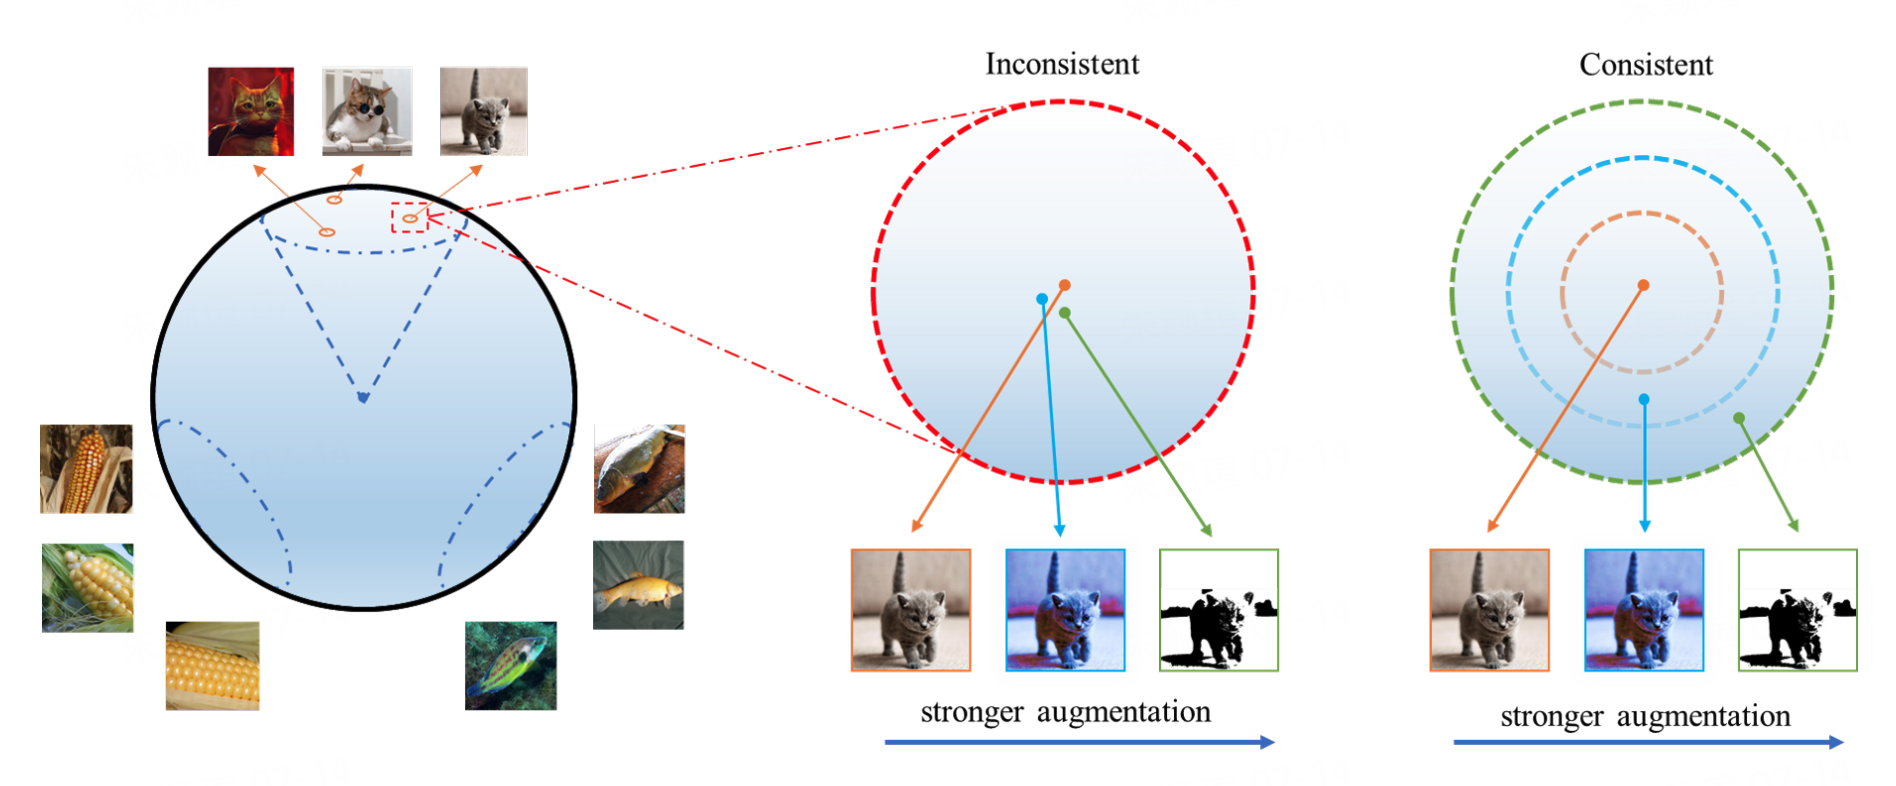

In [1]:
from IPython import display
display.Image("./images/cat_example.png")

## Defining Series of Data Augmentations

To address this distinction, Wang et al. introduced the concept of $A(\cdot)$, which represents the series of augmentations applied to the input. These augmentations, denoted as $T_1, \ldots, T_k$ (such as rotation, affine translation, noise generation), can be combined to form $A = T_1 \cdot \ldots \cdot T_l$. The vector representation of $A$, denoted as $V(A)$, is a $k$-dimensional array where each index $i$ ($1 \leq i \leq k$) corresponds to the number of times the transformation $T_i$ appears in $A$. This representation assumes that the order in which the augmentations are applied remains constant. While this simplifies subsequent computations, it fails to address an important factor: the order of applying the augmentations does have an impact.

Consider an input image where random noises are added first, followed by enhancing saturation. The resulting image may deviate significantly from the original compared to applying the augmentations in reverse order. However, simply defining $V'(A)$ as an array of length $l$, where each index $i$ ($1 \leq i \leq l$) represents the index of the $j^{th}$ ($1 \leq j \leq k$) augmentation used, introduces a problem of variable-length $V(A)$. To overcome this issue, one potential solution is to leverage embedding techniques from natural language processing to convert $A$ into a vector of constant dimensions.

## Defining Latent Deviation

The latent deviation of an augmentation combination $A$ is defined as the angular difference between $f_{\theta_e}(A(x))$ and $f_{\theta_e}(x)$, denoted as $\Omega(x; f_{\theta_e}, A) = f_{\theta_e}(x)^T \cdot f_{\theta_e}(A(x))$.

## Using Latent Deviation to Define Data Augmentation Consistency

Building upon the concept of latent deviation, we can now introduce the Data Augmentation Consistency Level (DACL).

$\text{DACL}(x, f_{\theta_e}; f^*, A) = \mathbb{E}[|\Omega(x; f_{\theta_e}, A) - \Omega(x; f^*_{\theta_e}, A)|]$, where $f^*_{\theta_e}$ represents the theoretically optimized embedding network that accounts for the deviation in the latent space.

Our objective is to find the "optimal latent deviation," and to achieve this, we define a loss function: $L_{consistency} = \text{DACL}(x, f_{\theta_e}; f^*, A) = \mathbb{E}[|\Omega(x; f_{\theta_e}, A) - \Omega(x; f^*_{\theta_e}, A)|]$.

However, the consistency loss function faces a challenge as $f^*_{\theta_e}$ is not well-defined. To overcome this, we introduce a model that takes $A$ as input and outputs $\Omega$, denoted as $g_{\theta_d}: V(A) \rightarrow \Omega(X; f_{\theta_e}, A)$, where $X$ represents the entire dataset. By employing contrastive learning, the total loss function becomes the sum of $L_{contrastive}$ and $L_{consistency}$.

$$
L_{total}(\theta_e, \theta_d) = L_{contrastive}(\theta_e) + L_{consistency}(\theta_e, \theta_d)\\
     = L_{contrastive}(\theta_e) + \mathbb{E}[|\Omega(x; f_{\theta_e}, A) - \Omega(x; f^*_{\theta_e}, A)|]\\
     = L_{contrastive}(\theta_e) + \mathbb{E}[|\Omega(x; f_{\theta_e}, A) - g_{\theta_d}(x, f_{\theta_e}, A)|]
$$

Since $g_{\theta_d}$ maps the augmentations to the latent deviations, it follows that it is a monotonically increasing function: as the value of $||V(A)||$ increases, the augmentation strength grows, leading to larger values of $\Omega(x; f_{\theta_e}, A)$. To ensure this property, we employ a partially monotonic neural network architecture, which enforces monotonicity constraints on specific input variables, for $g_{\theta_e}$.

## Bi-optimization

Simultaneously training $f_{\theta_e}$ and $g_{\theta_d}$ presents challenges. To address this, we adopt the following algorithm:

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import StepLR
from torchvision import models

class TripletDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        anchor, _ = self.mnist_dataset[index]
        positive, _ = self.mnist_dataset[index]
        negative, _ = self.mnist_dataset[index + 1]
        return anchor, positive, negative

    def __len__(self):
        return len(self.mnist_dataset) - 1

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.pairwise_distance(anchor, positive)
        distance_negative = torch.pairwise_distance(anchor, negative)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return loss.mean()

class ConsistencyLoss(nn.Module):
    def __init__(self):
        super(ConsistencyLoss, self).__init__()

    def forward(self, augmented_output, original_output, g_output):
        loss = np.abs(np.dot(augmented_output.detach().numpy().transpose(), original_output.detach().numpy()) - g_output.detach().numpy())
        return loss.mean()
    
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet(x)
    
class PartiallyMonotonicNet(nn.Module):
    def __init__(self, input_size = 5, hidden_size = 256, output_size = 1, monotonic_variables = [0, 1, 2, 3 ,4]):
        super(PartiallyMonotonicNet, self).__init__()
        self.monotonic_variables = monotonic_variables
        
        # Define the layers for the neural network
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply monotonicity constraints to selected variables
        for var in self.monotonic_variables:
            x[:var] = torch.cummax(x[:var], dim=0)[0]

        # Forward pass through the network
        x = self.fc1(x.float())
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def vectorize(A, T):
    vector = [0] * len(T)
    for augmentation in A:
        vector[T.index(augmentation)] += 1
    return vector

def train(model, g_model, dataloader, triplet_criterion, consistency_criterion, optimizer, T, device):
    model.train()
    for anchor, positive, negative in dataloader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_embedding = model(anchor)
        positive_embedding = model(positive)
        negative_embedding = model(negative)
        triplet_loss = triplet_criterion(anchor_embedding, positive_embedding, negative_embedding)
        A = []
        num_augments = random.randint(1, 10) # total augmentations not greater than 10
        for i in range(num_augments):
            A.append(random.choice(T))
        V = torch.tensor(vectorize(A, T))
        augmented_anchor = anchor
        for augmentation in A:
            augmented_anchor = augmentation(augmented_anchor)
        augmented_embedding = model(augmented_anchor)
        optimal_latent_deviation = g_model(V)
        consistency_loss = consistency_criterion(augmented_embedding, anchor_embedding, optimal_latent_deviation)
        loss = triplet_loss + consistency_loss
        loss.backward()
        optimizer.step()

def main():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Define hyperparameters
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10

    # Load the MNIST dataset
    train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
    train_dataset = TripletDataset(train_dataset)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create the embedding network (ResNet-18)
    embedding_net = ResNet18()

    # Create the triplet network
    model = nn.Sequential(
        embedding_net,
    )
    
    # Create the PMNN network
    g_model = PartiallyMonotonicNet()
    
    # Define the set of augmentations T
    def random_rotation(x):
        angle = torch.rand(x.shape[0]) * 360  # Generate random angles between 0 and 360
        return torch.stack([TF.rotate(x[i], angle[i].item()) for i in range(x.shape[0])])

    def random_saturation(x):
        # Define the saturation range (adjust as desired)
        saturation_range = (0.5, 1.5)  # random saturation between 0.5 and 1.5
        transform = transforms.ColorJitter(saturation=saturation_range)
        return transform(x)
    
    def random_translation(x):
        translation_range = (0.3, 0.3)  # random translation between -10 and 10 pixels
        transform = transforms.RandomAffine(0, translate=translation_range)
        return transform(x)
    
    def random_flip(x):
        return torch.flip(x, dims=(0,))
    
    def random_noise(x):
        noise_level = 0.1  # standard deviation of the noise
        noise = torch.randn_like(x) * noise_level
        return x + noise
        
    T = [
        random_rotation, 
        random_saturation, 
        random_translation, 
        random_flip, 
        random_noise
    ]

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Define the criterion, optimizer, and learning rate scheduler
    triplet_criterion = TripletLoss()
    consistency_criterion = ConsistencyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # Training loop
    for epoch in range(num_epochs):
        train(model, g_model, train_dataloader, triplet_criterion, consistency_criterion, optimizer, T, device)
        scheduler.step()

if __name__ == '__main__':
    main()

## Semi-Supervised Learning

Training $g_{\theta_d}$ faced one last problem: using merely unlabeled data, it is hard to produce the desired result, since both the initial $g_{\theta_d}$ and the initial $f_{\theta_e}$ produce highly inaccurate results, we need to finetune the network using a small amount of labeled data. The loss function is simply a cross entropy loss between the label and the predicted $\hat{y}$: 
$$
\text{CE}(\text{label}_x, f^*_{\theta_e}(x)),
$$
where $\text{CE}$ denotes the cross entropy loss, and the loss function is subject to the constraint that $f^*_{\theta_e}$ is obtained through $L_{total}$.